In [90]:
from IPython.display import HTML
HTML('''<script> code_show=true;  
function code_toggle() {
 if (code_show){  $('div.input').hide(); 
 } else {  $('div.input').show();  }
 code_show = !code_show
}
$( document ).ready(code_toggle); </script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')



In [91]:
from datetime import datetime, date

In [92]:
from IPython.html.widgets import interact, interactive, fixed

In [93]:
%reload_ext autoreload
%autoreload 2

In [94]:
from model import *

In [95]:
from cytoolz import sliding_window, count, pipe, thread_first

In [96]:
import seaborn as sns
%matplotlib notebook


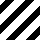
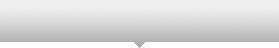
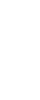
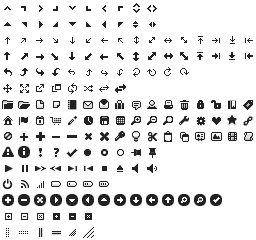
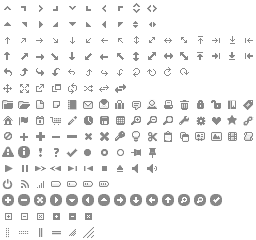
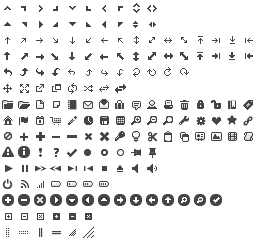
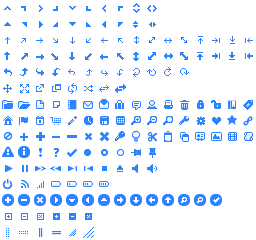
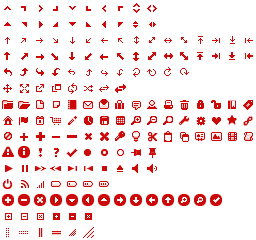
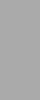
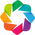
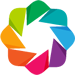
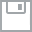
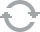
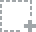
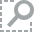
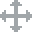
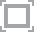
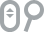

In [97]:
from bokeh.plotting import *
from bokeh.models import TapTool

output_notebook()

#Value at Risk

Value at risk (VaR) is a very popular measure of the risk of loss on a portfolio of financial assets.
For a given
- portfolio,
- time horizon, and
- probability $p$,

the $100p%$ VaR is defined as a threshold loss value, such that the probability that the loss on the portfolio over the given time horizon exceeds this value is p.

## Definition

Given a confidence level $\alpha \in (0,1)$, the VaR of the portfolio at the confidence level $\alpha$
is given by the smallest number $l$ such that the probability that the loss $L$ exceeds $l$ is at most $(1-\alpha)$.
Mathematically, if $L$ is the loss of a portfolio, then $\operatorname{VaR}_{\alpha}(L)$ is the level $\alpha$-quantile, i.e.

$$\operatorname{VaR}_\alpha(L)=\inf\{l \in \mathbb{R}:P(L>l)\le 1-\alpha\}= \\
= \inf\{l\in \mathbb{R}:F_L(l) \ge \alpha\}.$$

### Load risk factors using Blaze

They correspond to
- Deutsche Bank (in USD)
- EURUSD

In [98]:
DATA_DIR = "../../osqf2015/data/"
rf1 = RiskFactor.from_blaze(DATA_DIR + "db2.bcolz")
rfeurusd = CurrencyRiskFactor.from_blaze(DATA_DIR + "eurusd.bcolz")

## Filtered Historical Simulation

We are interested in the daily price changes, i.e. the daily returns, more specifically the daily log-returns.

$ r_t = log\left( \frac{p_t}{p_{t-1}} \right)$

These are

1. filtered in order to make them independent from local volatility

2. used for generating a set of scenarios, i.e. projections of the possible price evolution based on the history

The VaR is the percentile of distribution of the loss occurring from each computed scenario.

The bootstrapped FHS method requires the observations to be approximately independent and identically distributed.
However, most financial return series exhibit some degree of autocorrelation and, more importantly, heteroskedasticity.

## Estimating local volatility

### Exponentially Weighted Standard Deviation
We estimate the local volatility by means of the exponentially weighted standard deviation, given by
$$\sigma^2_t = (1 - \lambda) r_t^2 + \lambda \sigma^2_{t-1}$$
where $\lambda$ is a parameter that should be fitted. A common value is $\lambda = 0.94$, following the recommendation from JP Morgan: 
http://www.phy.pmf.unizg.hr/~bp/TD4ePt_2.pdf
The impact of the parameter $\lambda$ can be seen in the widget below.

In [99]:
rf1.logreturns()
rf1.devol()

## How the Bokeh interactive plots work

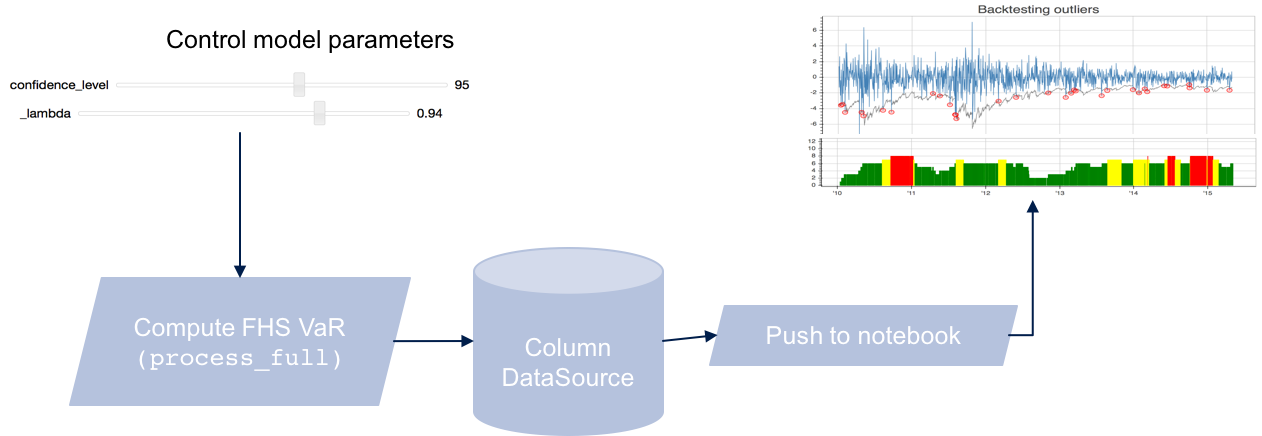

In [100]:
from IPython.display import Image
Image('bokeh_workflow.png')

In [101]:
def make_rf_ds(rf, start='2010-01-01', coordinates='relative'):
    """ construct data source """
    df = rf.ts[start:]
    src = ColumnDataSource(df)
    return src

ds_rf = make_rf_ds(rf1)
cfg = dict(l=0.94, src=ds_rf, rf=rf1)

In [102]:
def update_model(_lambda=0.94, cfg=fixed(cfg)):#risk_factor=fixed(rf1), src=fixed(rf_ds)):
    risk_factor = cfg['rf']
    src = cfg['src']
    risk_factor.devol(_lambda=1.-_lambda)
    update_rf_ds(risk_factor, src)
    src.push_notebook()

def update_rf_ds(rf, src, coordinates='relative', start='2010-01-01'):
    """ update data source """
    df = rf.ts[start:]
    src.data['LogReturns'] = df.LogReturns.values
    src.data['DevolLogReturns'] = df.DevolLogReturns.values
    src.data['Vola'] = df.Vola.values
#     src = ColumnDataSource.from_df(df)
    #src.data.update(df[['DevolLogReturns']].to_dict())
    return src

In [103]:
def make_rf_plot(src):
    p = figure(title=None, plot_height=250, plot_width=900, x_axis_type="datetime")
    p.line('Date', 'Vola', source=src, color='orange', fill_alpha=0.2, legend='Volatility')
    p.line('Date', 'LogReturns', source=src, line_width=1, color='steelblue', legend='Log Returns')
    p.min_border = 2
    p.min_border_top = 10
    p.min_border_bottom = 0
    
    p2 = figure(title=None, plot_height=250, plot_width=900, x_axis_type='datetime', x_range=p.x_range)
    p2.line('Date', 'DevolLogReturns', source=src, line_width=1, color='green', legend='Devolatilized Log Returns')
    p2.min_border = 2
    p2.min_border_top = 10
    p2.min_border_bottom =0

    return gridplot([[p],[p2]])

In [104]:
p = make_rf_plot(ds_rf)
show(p)

In [105]:
w = interact(update_model, _lambda=(0.80, 0.99, 0.01));
w.widget.msg_throttle = 3

In [106]:
metric = VaR(99)

## Scenario generation

We compute the normalized returns by subtracting the mean and dividing by the standard deviation, as follows

$ \xi_t = \frac{r_t - \mu}{\sigma_t}$

$ R_t = \exp( \xi_t \, \sigma_T ) $

$ S_t = R_t P_T $

In [107]:
scenarios = rf1.fhs()
df = pd.DataFrame(scenarios, index=rf1.ts.index)

## Backtesting

Control the predictive quality of the model. 

Outliers based on the assumption that they are binomial i.i.d. and perform Kupiec’s “proportion of failures” (PF) coverage test
http://www.value-at-risk.net/backtesting-coverage-tests/

For a time period, the traffic light system indicates how adequate the model is.

In [108]:
VaR.traffic_light

<bound method type.traffic_light of <class 'model.VaR'>>

In [109]:
def setup_results(df):
    """ Sets up the DataFrame with the computation results """
    results = pd.DataFrame({'neutral': df.icol(0),
                            'realized': df.shift(-1).icol(0)},
                            index=df.index )
    return results

def quantile_results(results, df, level):
    """ Adds quantile columns to the results dataframe """
    n_scenarios = len(df.columns) - 1
    results['q_upper'] = df.icol(np.arange(1,n_scenarios+1)).apply(np.percentile, axis=1, q=level)
    results['q_lower'] = df.icol(np.arange(1,n_scenarios+1)).apply(np.percentile, axis=1, q=100.-level)
    results.eval('shortfall = q_lower - realized')
    results.eval('shortfall_mid = shortfall * 0.5')
    return results

def mark_outliers(df, level):
    """ Based on the quantiles, determines the existence of outliers
    and aggregates these using a sliding window """
    is_outlier = df.eval('(q_lower > realized)')
    df.loc[is_outlier,'bad'] = df[is_outlier]['realized']
    is_outlier = df.eval('q_upper < realized')
    df.loc[is_outlier,'good'] = df[is_outlier]['realized']
    
    n_outliers = pd.stats.moments.rolling_count(df.bad, 250)
    df['outliers'] = n_outliers
    m = VaR(level/100.)
    stat = m.likelihood_statistic(n_outliers, 250)
    df['lights'] = VaR.traffic_light(m.confidence(stat))
    return df

In [110]:
def process_full(df, level=99, start='2010-01-01'):
    """ Processing pipeline  """
    df_restricted = df[df.index > start]
    return thread_first(df_restricted,
                        setup_results,
                        (quantile_results, df_restricted, level),
                        (mark_outliers, level),
                        lambda x: x.ix[:-2])

### Generation of a ColumnDataSource for a plot

In [111]:
def append_reverse(a, b):
    return np.append(a, np.flipud(b))

def make_envelope_ds(df, coordinates='relative'):
    """ construct data source """
    src = ColumnDataSource()
    d = df.index.tolist()
    src.add(append_reverse(d,d), 'date')
    return src

def update_envelope_ds(df, src, coordinates='relative'):
    """ update data source """
    factor = 0. if coordinates == 'absolute' else df.neutral
    y = append_reverse((df.q_lower - factor).values,
                       (df.q_upper - factor).values)
    src.add(y.tolist(), 'var')
    src.add((df.good - factor).values, 'good')
    src.add((df.bad - factor).values, 'bad')
    src.add((df.realized - factor).values, 'realized')
    return src

def make_outlier_ds(df):
    src = ColumnDataSource()
    src.add( df.index.tolist(), 'date')
    return src

def update_outlier_ds(df, src):
    src.add( df.outliers.values, 'outliers')
    src.add( df.outliers.values * 0.5, 'outliers_mids')
    colors = np.array(['green', 'yellow', 'red'])
    src.add(colors[df.lights.values], 'lights')
    return src


### Plot creation

In [112]:
def make_envelope_plot(src):
    p = figure(title="Backtesting outliers", plot_height=400, plot_width=900, x_axis_type="datetime")
#     p.patch('date', 'var', source=src, color='grey', fill_alpha=0.2)
    p.line('date', 'var', source=src, color='grey', fill_alpha=0.2)
    p.line('date', 'realized', source=src, line_width=1, color='steelblue')
#     p.scatter(x='date', y='good', source=src, size=10, color='green', fill_alpha=0.2, )
    p.scatter(x='date', y='bad', source=src, size=10, color='red', fill_alpha=0.2, )
    p.min_border = 5
    p.min_border_top = 10
    p.min_border_bottom = 0
    return p

In [113]:
def make_outlier_plot(src, range_obj):
    p = figure(plot_height=200, plot_width=900, x_axis_type="datetime", x_range=range_obj)
    w = 20*60*60*1000 # half day in ms
    p.rect(x="date", y='outliers_mids', width=w, height='outliers', color='lights', fill_alpha=0.3, source=src)
    p.min_border = 5
    p.min_border_top = 10
    p.min_border_bottom = 0
    return p

In [114]:
df_res = process_full(df)

In [115]:
ds_envelope = make_envelope_ds(df_res)
ds_envelope = update_envelope_ds(df_res, ds_envelope)

In [116]:
ds_outliers = make_outlier_ds(df_res)
ds_outliers = update_outlier_ds(df_res, ds_outliers)

## Update functions

In [117]:
# Configuration object
c = dict(confidence_level=99, l=0.94, src=ds_envelope, src_out=ds_outliers, df=df)

In [118]:
def update_confidence_level(confidence_level=94, cfg=fixed(c)):
    cfg['confidence_level'] = confidence_level
    df_res = process_full(df, level=cfg['confidence_level'])
#     print( df_res.tail())
    ds = update_envelope_ds(df_res, cfg['src'])
    ds_outliers = update_outlier_ds(df_res, cfg['src_out'])
    # propagate changes to plot
    ds.push_notebook()
    ds_outliers.push_notebook()

In [119]:
def update_lambda(_lambda=0.94, cfg=fixed(c)):
    cfg['l'] = 1. - _lambda
    rf1.devol(_lambda=1. - _lambda)
    df = pd.DataFrame(rf1.fhs(), index=rf1.ts.index)
    cfg['df'] = df
    df_res = process_full(df, level=cfg['confidence_level'])
    ds = update_envelope_ds(df_res, cfg['src'])
    ds_outliers = update_outlier_ds(df_res, cfg['src_out'])
    # propagate changes to plot
    ds.push_notebook()
    ds_outliers.push_notebook()

In [120]:
p_envelope = make_envelope_plot(ds_envelope)
p_traffic_lights = make_outlier_plot(ds_outliers, p.x_range)
show(gridplot( [[p_envelope],[p_traffic_lights]]))

In [121]:
interact(update_confidence_level, confidence_level=(90, 99, 1));
interact(update_lambda, _lambda=(0.80, 0.99, 0.01));

<IPython.core.display.Javascript object>


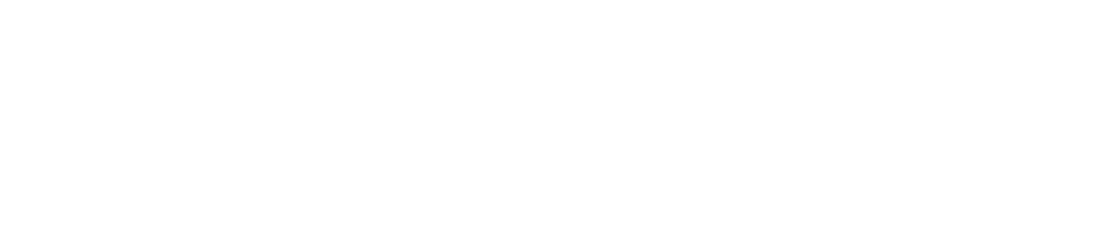

In [122]:
%matplotlib notebook
rf1.ts.Value.loc['01-01-2010':].plot(figsize=(14,3))

<IPython.core.display.Javascript object>


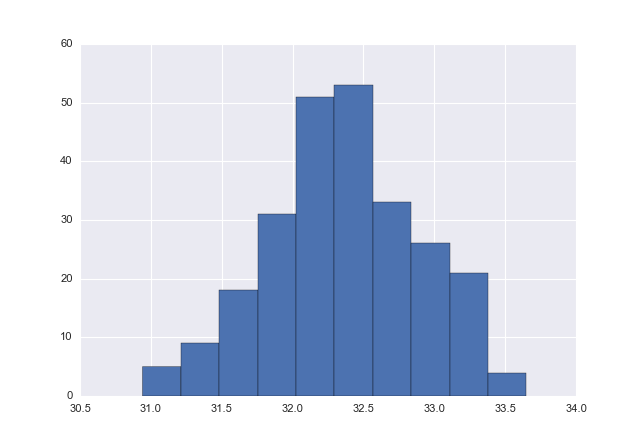

(array([  5.,   9.,  18.,  31.,  51.,  53.,  33.,  26.,  21.,   4.]),
 array([ 30.94119106,  31.21203887,  31.48288668,  31.7537345 ,
         32.02458231,  32.29543013,  32.56627794,  32.83712576,
         33.10797357,  33.37882139,  33.6496692 ]),
 <a list of 10 Patch objects>)

In [123]:
%matplotlib notebook
sns.plt.hist(scenarios[-1,:])